In [1]:
import os
import math
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from optimization.models import utils
import optuna
from optimization.models import NNModels
from optimization.models import utils
from optimization.models import SequenceSignal
from optimization.models.SequenceSignal import Sequence
from optimization.models import transformer_model, transformer_model2, transformer_model3, RNN_embeddings
from optimization.models import transformer_model_CLS_token
from optimization.models import CNN_model, transformer_model_specific_encoder
from optimization.models import train_val_loops2
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay
from sklearn.metrics import precision_score, recall_score, auc, roc_curve
from sklearn.metrics import auc
from scipy.stats import pearsonr
import pandas as pd
from torchinfo import summary
import math
import numpy as np
from sklearn.preprocessing import normalize

In [2]:
# Global variables
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 64
N_EPOCHS = 30
OUTPUT_SHAPE = 9
SEQ_LENGTH = 2000
WINDOW_SIZE = '1kb'
SIGNAL_SIZE = 300
N_TEST_EXAMPLES = np.load(f'dELS_classification/val_target.npy').shape[0]
N_TRAIN_EXAMPLES = np.load(f'dELS_classification/train_target.npy').shape[0]
PATIENCE = 20

In [3]:
epsilon = 1e-6  # to avoid division by zero

n_pos = np.load(f'dELS_classification/train_target.npy').sum(axis=0)
n_neg = (1.0 - np.load(f'dELS_classification/train_target.npy')).sum(axis=0)

# pos_weight = n_neg / n_pos (1 value per class)
pos_weight = n_neg / (n_pos + epsilon)
pos_weight = torch.Tensor(pos_weight).to(DEVICE)

In [4]:
model = transformer_model2.TransformerCNNMixtureModel(n_conv_layers = 4, n_filters = [256, 60, 60, 120], 
                                   kernel_sizes = [7, 3, 5, 3], dilation = [1, 1, 1, 1], 
                                   drop_conv = 0.1, n_fc_layers = 2, 
                                   drop_fc = 0.4, sequence_length = SEQ_LENGTH, 
                                   n_neurons = [256, 256], output_size = OUTPUT_SHAPE, drop_transformer=0.2, input_size=4, 
                                                     n_encoder_layers = 2, n_heads=8, n_transformer_FC_layers=256)

model.to(device=DEVICE)
CRITERION = torch.nn.BCEWithLogitsLoss(pos_weight=torch.Tensor(pos_weight))
summary(model)

Layer (type:depth-idx)                                            Param #
TransformerCNNMixtureModel                                        --
├─ModuleList: 1-1                                                 --
│    └─Sequential: 2-1                                            --
│    │    └─ConvPoolingBlock: 3-1                                 7,936
│    └─Sequential: 2-2                                            --
│    │    └─ConvPoolingBlock: 3-2                                 46,260
│    └─Sequential: 2-3                                            --
│    │    └─ConvPoolingBlock: 3-3                                 18,180
│    └─Sequential: 2-4                                            --
│    │    └─ConvPoolingBlock: 3-4                                 21,960
├─PositionalEncoding: 1-2                                         --
├─TransformerEncoder: 1-3                                         --
│    └─ModuleList: 2-5                                            --
│    │    └─Tr

In [5]:
class_props = n_pos/np.load(f'dELS_classification/train_target.npy').shape[0]
# y_true_array.shape = (n_samples, n_classes)
n_samples, n_classes = N_TEST_EXAMPLES, OUTPUT_SHAPE

# Compute class proportions
std = 0.05  # tweak this std for noise level

# Generate noisy probabilities
probs_baseline = np.random.normal(loc=class_props, scale=std, size=(n_samples, n_classes))

# Clip to [0, 1] since these are probabilities
probs_baseline = np.clip(probs_baseline, 0, 1)

In [6]:
dataloaders = utils.load_dataset(f'dELS_classification/dataset_train_augmented_encoding.npy', 
                                 f'dELS_classification/train_target.npy', 
                                 f'dELS_classification/dataset_1kb_val_encoding.npy', 
                                 f'dELS_classification/val_target.npy', 
                                 BATCH_SIZE, device = DEVICE, 
                                 sqrt_transform = False,
                                 num_mutations = 0)

In [7]:
optimizer = torch.optim.Adam(params = model.parameters(), lr = 1e-3, weight_decay = 1e-4)
#optimizer = torch.optim.AdamW(params = model.parameters(), lr = 1e-3, weight_decay = 1e-4)
#optimizer = torch.optim.SGD(params = model.parameters(), lr = 1e-3, momentum = 0.9)
#lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', threshold = 1e-1)
lr_scheduler = optim.lr_scheduler.OneCycleLR(optimizer, epochs = N_EPOCHS, max_lr = 1e-3, 
                                             steps_per_epoch = math.ceil(N_TRAIN_EXAMPLES / dataloaders[0].batch_size), 
                                             pct_start = 0.1, anneal_strategy = 'linear')

In [8]:
#training_state = torch.load(f'checkpoint_{WINDOW_SIZE}_{SIGNAL_SIZE}bp.pth', weights_only = True)
training_state = torch.load(f'checkpoint.pth', weights_only = True)
model.load_state_dict(training_state['network'])

<All keys matched successfully>

In [9]:
output=train_val_loops2.train_N_epochs(model, optimizer, criterion = CRITERION, 
                                          train_loader = dataloaders[0], valid_loader = dataloaders[1], 
                                          num_epochs = N_EPOCHS, verbose = True, patience = PATIENCE, 
                                          model_path = 'checkpoint2.pth', lr_scheduler=None)

Training model:
TransformerCNNMixtureModel(
  (convs): ModuleList(
    (0): Sequential(
      (0): ConvPoolingBlock(
        (block): Sequential(
          (0): Conv1d(4, 256, kernel_size=(7,), stride=(1,))
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Dropout1d(p=0.1, inplace=False)
          (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
      )
    )
    (1): Sequential(
      (0): ConvPoolingBlock(
        (block): Sequential(
          (0): Conv1d(256, 60, kernel_size=(3,), stride=(1,))
          (1): BatchNorm1d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Dropout1d(p=0.1, inplace=False)
          (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
      )
    )
    (2): Sequential(
      (0): ConvPoolingBlock(
        (block): Sequential(
          (0): C

KeyboardInterrupt: 

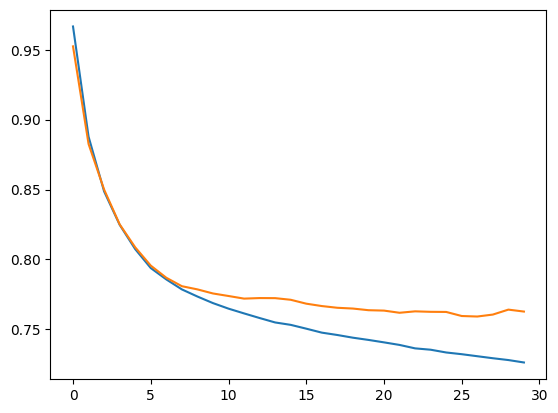

In [10]:
plt.plot(output[0][0])
plt.plot(output[0][1])
plt.show()

In [9]:
model.eval()
y_predict_scratch = torch.zeros((N_TEST_EXAMPLES, OUTPUT_SHAPE), device = DEVICE)
#y_predict_transfer = torch.zeros((N_TEST_EXAMPLES, OUTPUT_SHAPE), device = DEVICE)
y_true = torch.zeros((N_TEST_EXAMPLES, OUTPUT_SHAPE), device = DEVICE)


with torch.inference_mode():

    for i, data in enumerate(dataloaders[1], 0):
        inputs, labels = data
        y_predict_scratch[(i * BATCH_SIZE):(i * BATCH_SIZE + BATCH_SIZE)] = model(inputs)
        #y_predict_transfer[(i * BATCH_SIZE):(i * BATCH_SIZE + BATCH_SIZE)] = model_2(inputs)
        y_true[(i * BATCH_SIZE):(i * BATCH_SIZE + BATCH_SIZE)] = labels

y_true_array = y_true.cpu().numpy()
#y_predict_array_transfer = (y_predict_transfer).cpu().numpy()
y_predict_array_scratch = (y_predict_scratch).cpu().numpy()
print(CRITERION(y_predict_scratch, y_true))
#print(CRITERION(y_predict_transfer, y_true))

tensor(0.7584, device='cuda:0')


In [10]:
def softmax(logits):
    # Subtract max for numerical stability
    logits_stable = logits - np.max(logits, axis=1, keepdims=True)
    exp_logits = np.exp(logits_stable)
    return exp_logits / np.sum(exp_logits, axis=1, keepdims=True)

#probs_transfer = softmax(y_predict_array_transfer)
probs_scratch = softmax(y_predict_array_scratch)

0.6681444268057405
0.5106395279145861
0.5127414074667128
0.303502908562169
0.6420956966145048
0.6511231618014721
0.5653148877612124
0.32658750838139194
0.5915081850484452


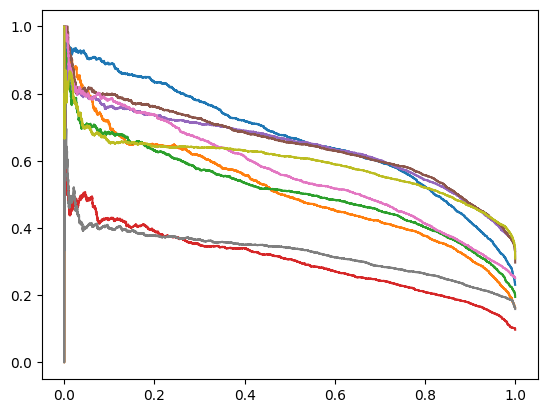

In [11]:
for j in range(OUTPUT_SHAPE):
    y, x, _ = precision_recall_curve(y_true_array[:, j], probs_scratch[:, j])
    plt.plot(x, y)
    print(auc(x, y))
    #y, x, _ = roc_curve(y_true_array[:, j], probs[:, j])
    #plt.plot(y, x)
    #print(auc(y, x))

In [12]:
# y_true_array.shape = (n_samples, n_classes)
n_samples, n_classes = N_TEST_EXAMPLES, OUTPUT_SHAPE

# Compute class proportions
std = 0.05  # tweak this std for noise level

# Generate noisy probabilities
probs_baseline = np.random.normal(loc=class_props, scale=std, size=(n_samples, n_classes))

# Clip to [0, 1] since these are probabilities
probs_baseline = np.clip(probs_baseline, 0, 1)

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve, auc
import os
# Optional: set Seaborn style for publication
# sns.set(style="whitegrid", palette="colorblind", context="talk")
#tissues = ['WID', 'EAD', 'AB', 'E5', 'E11', 'E13', 'HID', 'O', 'LB']
tissues = ['AB', 'E11', 'E13', 'E5', 'EAD', 'HID', 'LB', 'O', 'WID']
# Directory to save PR curves
output_dir = "pr_curves"
os.makedirs(output_dir, exist_ok=True)

# Replace with the number of classes you have
num_classes = y_true_array.shape[1]

# Loop over each class
for j in range(num_classes):
    plt.figure(figsize=(6, 5))

    # Model 1: probs
    precision1, recall1, _ = precision_recall_curve(y_true_array[:, j], probs_scratch[:, j])
    auc1 = auc(recall1, precision1)
    plt.plot(recall1, precision1, label=f"Model scratch (AUC = {auc1:.3f})")

    #precision2, recall2, _ = precision_recall_curve(y_true_array[:, j], probs_transfer[:, j])
    #auc2 = auc(recall2, precision2)
    #plt.plot(recall2, precision2, label=f"Pretrained model (AUC = {auc2:.3f})")


    # Model 2: probs_baseline
    precision3, recall3, _ = precision_recall_curve(y_true_array[:, j], probs_baseline[:, j])
    auc3 = auc(recall3, precision3)
    plt.plot(recall3, precision3, label=f"Baseline random model (AUC = {auc3:.3f})")

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve (Class {tissues[j]})")
    plt.legend()
    plt.tight_layout()

    # Save as PDF
    plt.savefig(os.path.join(output_dir, f"pr_curve_class_{tissues[j]}.pdf"))
    plt.close()


In [13]:
val = Sequence('model_validation/validation_interval_encoding.npy', device = DEVICE)
size = len(val)
val = DataLoader(val, batch_size = BATCH_SIZE, shuffle = False)

model.eval()
y_predict = torch.zeros((size, OUTPUT_SHAPE), device = DEVICE)

with torch.inference_mode():

    for i, data in enumerate(val, 0):
        y_predict[(i * BATCH_SIZE):(i * BATCH_SIZE + BATCH_SIZE)] = model(data)


In [14]:
y_predict_array = softmax((y_predict).cpu().numpy())

In [15]:
np.savetxt("model_validation/val_predictions.txt", y_predict_array, fmt='%f\t')

In [17]:
val = Sequence('motif_embedding_test/motif2/random_dna_sequences_with_UAS_encoding.npy', device = DEVICE)
size = len(val)
val = DataLoader(val, batch_size = BATCH_SIZE, shuffle = False)

model.eval()
y_predict = torch.zeros((size, OUTPUT_SHAPE), device = DEVICE)

with torch.inference_mode():

    for i, data in enumerate(val, 0):
        outputs_denorm = model(data)
        y_predict[(i * BATCH_SIZE):(i * BATCH_SIZE + BATCH_SIZE)] = outputs_denorm

y_predict_array_UAS = (y_predict).cpu().numpy()

val = Sequence('motif_embedding_test/motif2/random_dna_sequences_with_GAF1_encoding.npy', device = DEVICE)
size = len(val)
val = DataLoader(val, batch_size = BATCH_SIZE, shuffle = False)

model.eval()
y_predict = torch.zeros((size, OUTPUT_SHAPE), device = DEVICE)

with torch.inference_mode():

    for i, data in enumerate(val, 0):
        outputs_denorm = model(data)
        y_predict[(i * BATCH_SIZE):(i * BATCH_SIZE + BATCH_SIZE)] = outputs_denorm

y_predict_array_GAGA = (y_predict).cpu().numpy()

val = Sequence('motif_embedding_test/motif2/random_dna_sequences_with_grh_encoding.npy', device = DEVICE)
size = len(val)
val = DataLoader(val, batch_size = BATCH_SIZE, shuffle = False)

model.eval()
y_predict = torch.zeros((size, OUTPUT_SHAPE), device = DEVICE)

with torch.inference_mode():

    for i, data in enumerate(val, 0):
        outputs_denorm = model(data) 
        y_predict[(i * BATCH_SIZE):(i * BATCH_SIZE + BATCH_SIZE)] = outputs_denorm

y_predict_array_grh = (y_predict).cpu().numpy()

val = Sequence('motif_embedding_test/motif2/random_dna_sequences_with_ovo_encoding.npy', device = DEVICE)
size = len(val)
val = DataLoader(val, batch_size = BATCH_SIZE, shuffle = False)

model.eval()
y_predict = torch.zeros((size, OUTPUT_SHAPE), device = DEVICE)

with torch.inference_mode():

    for i, data in enumerate(val, 0):
        outputs_denorm = model(data)
        y_predict[(i * BATCH_SIZE):(i * BATCH_SIZE + BATCH_SIZE)] = outputs_denorm

y_predict_array_ovo = (y_predict).cpu().numpy()


val = Sequence('motif_embedding_test/motif2/random_dna_sequences_with_zelda_encoding.npy', device = DEVICE)
size = len(val)
val = DataLoader(val, batch_size = BATCH_SIZE, shuffle = False)

model.eval()
y_predict = torch.zeros((size, OUTPUT_SHAPE), device = DEVICE)

with torch.inference_mode():

    for i, data in enumerate(val, 0):
        outputs_denorm = model(data) 
        y_predict[(i * BATCH_SIZE):(i * BATCH_SIZE + BATCH_SIZE)] = outputs_denorm

y_predict_array_vfl = (y_predict).cpu().numpy()

val = Sequence('motif_embedding_test/motif2/random_dna_sequences_with_GAF2_encoding.npy', device = DEVICE)
size = len(val)
val = DataLoader(val, batch_size = BATCH_SIZE, shuffle = False)

model.eval()
y_predict = torch.zeros((size, OUTPUT_SHAPE), device = DEVICE)

with torch.inference_mode():

    for i, data in enumerate(val, 0):
        outputs_denorm = model(data) 
        y_predict[(i * BATCH_SIZE):(i * BATCH_SIZE + BATCH_SIZE)] = outputs_denorm

y_predict_array_GAGA_2 = (y_predict).cpu().numpy()

val = Sequence('motif_embedding_test/motif2/random_dna_sequences_with_GAF3_encoding.npy', device = DEVICE)
size = len(val)
val = DataLoader(val, batch_size = BATCH_SIZE, shuffle = False)

model.eval()
y_predict = torch.zeros((size, OUTPUT_SHAPE), device = DEVICE)

with torch.inference_mode():

    for i, data in enumerate(val, 0):
        outputs_denorm = model(data) 
        y_predict[(i * BATCH_SIZE):(i * BATCH_SIZE + BATCH_SIZE)] = outputs_denorm

y_predict_array_GAGA_3 = (y_predict).cpu().numpy()

val = Sequence('motif_embedding_test/motif2/random_dna_sequences_with_GAF4_encoding.npy', device = DEVICE)
size = len(val)
val = DataLoader(val, batch_size = BATCH_SIZE, shuffle = False)

model.eval()
y_predict = torch.zeros((size, OUTPUT_SHAPE), device = DEVICE)

with torch.inference_mode():

    for i, data in enumerate(val, 0):
        outputs_denorm = model(data) 
        y_predict[(i * BATCH_SIZE):(i * BATCH_SIZE + BATCH_SIZE)] = outputs_denorm

y_predict_array_GAGA_4 = (y_predict).cpu().numpy()

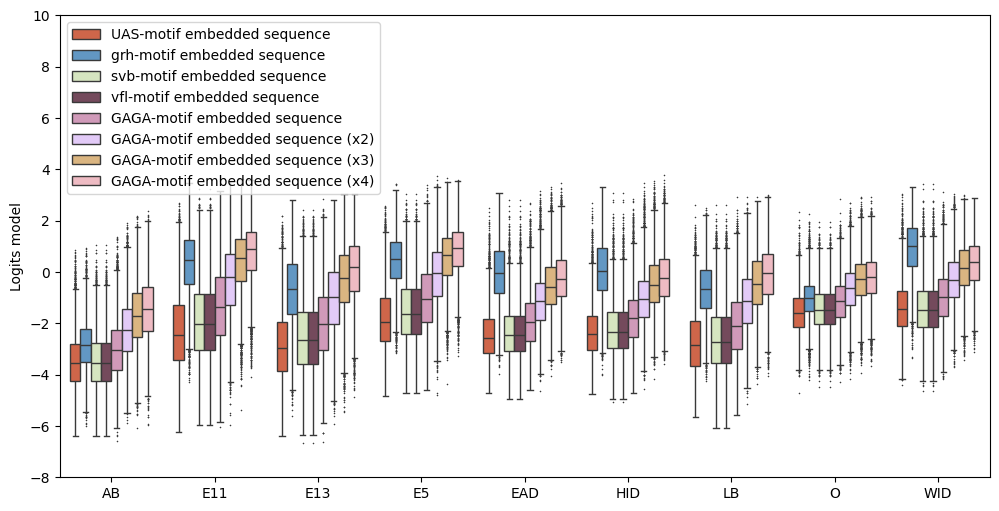

In [19]:
# Convert arrays into a DataFrame
columns = ['AB', 'E11', 'E13', 'E5', 'EAD', 'HID', 'LB', 'O', 'WID']
UAS = pd.DataFrame(y_predict_array_UAS, columns=columns)
GAGA = pd.DataFrame(y_predict_array_GAGA, columns=columns)
GAGA_2 = pd.DataFrame(y_predict_array_GAGA_2, columns=columns)
GAGA_3 = pd.DataFrame(y_predict_array_GAGA_3, columns=columns)
GAGA_4 = pd.DataFrame(y_predict_array_GAGA_4, columns=columns)
grh = pd.DataFrame(y_predict_array_grh, columns=columns)
ovo = pd.DataFrame(y_predict_array_ovo, columns=columns)
vfl = pd.DataFrame(y_predict_array_ovo, columns=columns)
# Add a column to indicate the type (predicted or true) and concatenate the dataframes
UAS['Type'] = 'UAS-motif embedded sequence'
grh['Type'] = 'grh-motif embedded sequence'
GAGA['Type'] = 'GAGA-motif embedded sequence'
GAGA_2['Type'] = 'GAGA-motif embedded sequence (x2)'
GAGA_3['Type'] = 'GAGA-motif embedded sequence (x3)'
GAGA_4['Type'] = 'GAGA-motif embedded sequence (x4)'
ovo['Type'] = 'svb-motif embedded sequence'
vfl['Type'] = 'vfl-motif embedded sequence'
# Combine both dataframes
df_combined = pd.concat([UAS, grh, ovo, vfl, GAGA, GAGA_2, GAGA_3, GAGA_4])
custom_palette = ["#E55934", "#5299D3", "#D7EBBA", "#7B435B", "#D991BA", '#E2C2FF', '#E9B872', '#F7B2BD'] 
# Melt the dataframe to make it compatible with seaborn
df_melted = df_combined.melt(id_vars='Type', var_name='Task', value_name='Value')

# Plot boxplots
plt.figure(figsize=(12, 6))
flierprops = dict(marker='x', color='black', markersize=0.5)
sns.boxplot(data=df_melted, x='Task', y='Value', hue='Type', palette = custom_palette, flierprops=flierprops)
plt.title("")
plt.xlabel("")
plt.ylim(-8, 10)
plt.ylabel("Logits model")
plt.legend(loc='upper left')
plt.show()

In [16]:
val = Sequence('EMBL_lines/line_sequences_encoding.npy', device = DEVICE)
BATCH_SIZE = 1
size = len(val)
val = DataLoader(val, batch_size = BATCH_SIZE, shuffle = False)

model.eval()
y_predict = torch.zeros((size, OUTPUT_SHAPE), device = DEVICE)

with torch.inference_mode():

    for i, data in enumerate(val, 0):
        y_predict[(i * BATCH_SIZE):(i * BATCH_SIZE + BATCH_SIZE)] = model(data)

y_predict_array = (2**y_predict).cpu().numpy()


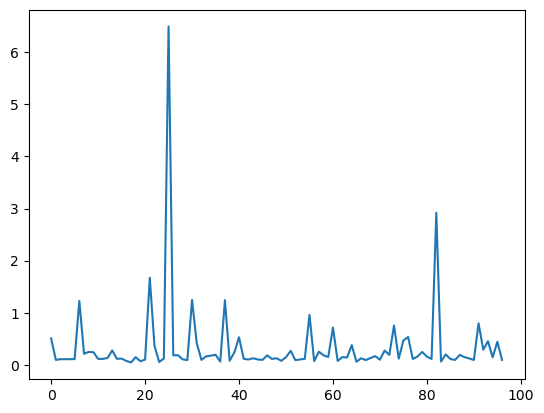

In [46]:
plt.plot(y_predict_array[:, 6])

In [20]:
columns = ['AB', 'E11', 'E13', 'E5', 'EAD', 'HID', 'LB', 'WID']

['AB', 'E11', 'E13', 'E5', 'EAD', 'HID', 'LB', 'WID']

In [42]:
(y_predict_array[:, 6])

array([0.50769836, 0.09491542, 0.10844931, 0.10777252, 0.10874664,
       0.11109876, 1.2285669 , 0.21283604, 0.24816881, 0.24273133,
       0.11438138, 0.11435296, 0.13092084, 0.27667922, 0.11587466,
       0.12013245, 0.07610258, 0.0454114 , 0.14746681, 0.06920592,
       0.09999237, 1.6714816 , 0.3645052 , 0.05518572, 0.12132969,
       6.495684  , 0.18204346, 0.18545118, 0.10526595, 0.0916217 ,
       1.246651  , 0.41581663, 0.09495295, 0.16335616, 0.17603968,
       0.19435215, 0.06199346, 1.2421461 , 0.0793155 , 0.23544149,
       0.5297793 , 0.11575283, 0.10218354, 0.12621869, 0.10340317,
       0.09524682, 0.1825427 , 0.11346289, 0.12648821, 0.07753294,
       0.14616418, 0.26838833, 0.08973405, 0.1033259 , 0.11523083,
       0.95823306, 0.07001836, 0.25291142, 0.18173908, 0.1516694 ,
       0.7162417 , 0.0742593 , 0.14948659, 0.14105599, 0.37787634,
       0.05958137, 0.12590292, 0.09159695, 0.1320472 , 0.16731402,
       0.09871289, 0.27456567, 0.19107766, 0.7527683 , 0.11853

In [50]:
y_predict_array[79, :]

array([0.19523716, 1.0442677 , 0.9929964 , 0.93860257, 0.28187022,
       0.3698214 , 0.24737567, 0.34753093], dtype=float32)

In [48]:
y_predict_array.shape

(97, 8)